# Classical shadows in linear optics

## Imports

In [1]:
include("../../src/LOShadows.jl")
using PyCall
using Plots
using Plots.PlotMeasures
pushfirst!(pyimport("sys")."path", "")
using LaTeXStrings
using Serialization
using Measures
using Printf
using Statistics
using Latexify
using Permutations
using Random
using RandomMatrices
using LinearAlgebra
using ImageUtils
using ColorSchemes
using Colors
using ColorVectorSpace
using ImageCore
using Distributions
using ZChop
using StatsPlots

In [2]:
using Logging; global_logger(ConsoleLogger(stdout,Logging.Warn))

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 72057594037927936, 0)), Info, Dict{Any, Int64}())

## Plots settings

In [3]:
default(fontfamily="Computer Modern", framestyle=:box, grid=false)

niceblue = RGB(67 / 255, 91 / 255, 236 / 255)
coolred = RGB(240 / 255, 115 / 255, 98 / 255)
green = RGB(11 / 255, 83 / 255, 69 / 255)
white = RGB(250 / 255, 250 / 255, 250 / 255)

## Application (a): Low-order correlators

In [4]:
function plot_two_point_correlators(all_snapshots, labels, dm)
	m = dm.m
	n = dm.n


	N = [[[s[j] for s in LOShadows.all_fock_states(m, i)] |> diagm for i in 0:n] |> LOShadows.direct_sum for j in 1:m]

	Π = LOShadows.inverse_channels(m, n)
	Cs = [LOShadows.apply_channel((snapshots |> sum) / length(snapshots), Π) for snapshots in all_snapshots]

	corr_ref = compute_two_point_correlator_matrix(dm)
	corr_shadow = [compute_two_point_correlator_matrix(C) for C in Cs]

	return plot_two_point(corr_ref, corr_shadow, labels)
end

function plot_two_point(ref, shadows, labels)
	ref = ref[end:-1:1, 1:end]
	shadows = [shadow[end:-1:1, 1:end] for shadow in shadows]
	b = max(abs(minimum(ref)), maximum(ref))
	@info labels[1]
	min_val = min(minimum(ref), minimum([minimum(shadow) for shadow in shadows]))
	max_val = max(maximum(ref), maximum([maximum(shadow) for shadow in shadows]))
	lims = (min_val, max_val)

	colors = max_val == 0 ? [niceblue, white] : [niceblue, white, coolred]
	cs = :lipari

	fontsize = 10

	plt_ref = plot_correlation_matrix(ref, lims, cs, "Objective", fontsize)
	shadows_plots_array = [plot_correlation_matrix(shadow, lims, cs, labels[i], fontsize) for (i, shadow) in enumerate(shadows)]

	color_bar = scatter([NaN], [NaN], zcolor = [NaN], clims = lims, label = "", c = cs, framestyle = :none, legend = :left, flipaxis = false)

	l = @layout [a{0.1w} Plots.grid(1, length(shadows) + 1)]

	fontsize = 8

	plt = Plots.plot(
		color_bar, plt_ref, shadows_plots_array...,
		layout = l,
        size = (800, 300),
		titlefontsize = fontsize,
	)

	return plt
end

function compute_two_point_correlator_matrix(dm)
	m = dm.m
	n = dm.n

	N = [LOShadows.direct_sum([[s[j] for s in LOShadows.all_fock_states(m, i)] |> diagm for i in 0:n]) for j in 1:m]

	corr = zeros(Float64, m, m)

	for i in 1:m
		for j in i:m
			n1 = N[i]
			n2 = N[j]
			n1n2 = n1 * n2
			tdm = tr(n1n2 * dm) - tr(n1 * dm) * tr(n2 * dm)

			corr[i, j] = real(tdm)
			corr[j, i] = real(tdm)
		end
	end

	return corr

end

function plot_correlation_matrix(mat, clims, cs, title, fontsize)
	return Plots.plot(heatmap(mat, color = cs, colorbar = false, aspect_ratio = :equal), clim = clims, lims = (0.5, size(mat)[1] + 0.5), xticks = 1:size(mat)[1], yticks = 1:size(mat)[2], xlabel = title, aspect_ratio = :equal,
		xtickfontsize = fontsize,
		ytickfontsize = fontsize,
		xlabelfontsize = fontsize,
		ylabelfontsize = fontsize,
		legendfontsize = fontsize,
	)
end


plot_correlation_matrix (generic function with 1 method)

## Application (b): Lie-algebraic linear optical invariants

In [5]:
function plot_invariant(all_snapshots, labels, colors, ρ; K=100)
    plt = Plots.plot(; layout=2)


    @time Π = LOShadows.inverse_channels(ρ.m, ρ.n)


    state_blocks = [[LOShadows.extract_blocks(s)[end] for s in snapshots] for snapshots in all_snapshots]

    @info "Compute average"
    Cs = [LOShadows.apply_channel((snapshots |> sum) / length(snapshots), Π)  for snapshots in all_snapshots]

    objective = LOShadows.linear_invariant(LOShadows.extract_blocks(ρ)[end]) |> real


    @info "CumSums"
    shadow_evolutions = [cumsum(state_block) for state_block in state_blocks]
    shadow_evolutions = [[sn / i for (i, sn) in enumerate(shadow_evolution)] for shadow_evolution in shadow_evolutions]

    shadows_idx = [length(shadow_evolutions[1]) ÷ 100 * i for i in 1:100]
    @info "Compute Shadow Linear Invariant"
    
    mean_invariants = [
        [LOShadows.linear_invariant(LOShadows.apply_nth_channel(state, Π[end])) |> real for (i, state) in enumerate(shadow_evolution) if i in shadows_idx]
        for shadow_evolution in shadow_evolutions
    ]

    p1 = Plots.plot(
        xlabel="% of samples",
        ylabel=L"$I(\rho)$",
        xtickfontsize=10,
        ytickfontsize=10,
        xlabelfontsize=10,
        ylabelfontsize=10,
        legendfontsize=8,
        linestyle=:solid,
        linewidth=2,
        margin=5mm,
        dpi=500,
    )


    for (i, mean_invariant) in enumerate(mean_invariants)
        Plots.plot!(
            1:length(mean_invariant), mean_invariant,
            color=colors[i],
            label=labels[i],
            linewidth=1.5,
        )
    end


    hline!(p1, [objective], linestyle=:dashdot, color=:red, label="True value", linewidth=1)

    sp_dm = real.(LOShadows.covariance_invariant(LOShadows.extract_blocks(ρ)[end]))
    sp_projection_dm = real.(LOShadows.tangent_invariant(LOShadows.extract_blocks(ρ)[end]))

    @info "Compute Shadow Nonlinear Invariant"

    p2 = scatter(
        0:m^2-1,
        sp_dm,
        label="True value",
        color=coolred,
        xlabel="Eigenvalue index",
        ylabel=L"$\lambda(\Gamma(\rho))$",
        xtickfontsize=10,
        ytickfontsize=10,
        xlabelfontsize=10,
        ylabelfontsize=10,
        legendfontsize=8,
        legend=:bottomright,
        linewidth=2,
        marker=:rect,
        markersize=4,
        markercolor=RGBA(1, 1, 1, 0),
        dpi=3000,
        margin=5mm,
        markerstrokewidth=1,
    )

    for (i, C) in enumerate(Cs)
        scatter!(p2,
            0:m^2-1,
            real.(LOShadows.covariance_invariant(LOShadows.extract_blocks(C)[end])),
            # yerror=std.(err),
            label=labels[i],
            marker=:star,
            markersize=4,
            color=colors[i],
            markerstrokewidth=0.5,
            # linewidth=2,
        )
    end


    p3 = scatter(
        0:m^2-1,
        sp_projection_dm,
        label="True value",
        color=coolred,
        xlabel="Eigenvalue index",
        ylabel=L"$\lambda(\rho_T)$",
        xtickfontsize=10,
        ytickfontsize=10,
        xlabelfontsize=10,
        ylabelfontsize=10,
        legendfontsize=8,
        legend=:bottomright,
        linewidth=2,
        marker=:rect,
        markersize=4,
        markercolor=RGBA(1, 1, 1, 0),
        dpi=3000,
        margin=5mm,
        markerstrokewidth=1,
    )

    for (i, C) in enumerate(Cs)
        scatter!(p3,
            0:m^2-1,
            real.(LOShadows.tangent_invariant(LOShadows.extract_blocks(C)[end])),
            # yerror=std.(err),
            label=labels[i],
            marker=:star,
            markersize=4,
            color=colors[i],
            markerstrokewidth=0.5,
            # linewidth=2,
        )
    end
        
    return Plots.plot(p1, p2, p3; layout=@layout(grid(1, 3; widths=(1/3, 1/3, 1/3))), size=(800, 270))
end


plot_invariant (generic function with 1 method)

## Application (c): Binned probabilities

In [14]:
function plot_binned_probabilities(all_snapshots, labels, colors, ρ)
    m, n = ρ.m, ρ.n
    all_bins = [
        [[1], [2, 3, 4]],
        [[2], [1, 3, 4]],
        [[3], [1, 2, 4]],
        [[4], [1, 2, 3]],
        [[1, 2], [3, 4]],
        [[1, 3], [2, 4]],
        [[1, 4], [2, 3]]
    ]

    t = 1 + length(all_snapshots)

    Π = LOShadows.inverse_channels(ρ.m, ρ.n)

    Cs = [LOShadows.extract_blocks(LOShadows.apply_channel((snapshots |> sum) / length(snapshots), Π))[end] for snapshots in all_snapshots]
    dm_last_block = LOShadows.extract_blocks(ρ)[end]

    all_plots = []

    for (i, bins) in enumerate(all_bins)
        binned_proba_obj = [LOShadows.binned_probability([k, n - k], bins, dm_last_block) for k in 0:n]
        binned_proba_shadows = [
            [LOShadows.binned_probability([k, n - k], bins, C) for k in 0:n] for C in Cs
        ]

        datasets = hcat([[binned_proba_obj]; binned_proba_shadows]...)

        sx = repeat(labels, inner=n + 1)
        nam = repeat((0:n), outer=t)
        col = repeat(colors, inner=n + 1)

        add_legend = false
        # 
        push!(all_plots,
            groupedbar(
                nam,
                datasets,
                group=sx,
                ylims=(0, 1),
                xlim=(-0.5, 3.5),# ylabel = "Proba", 
                legend=(i == 1) ? :topleft : false,
                color=col,
                titlefontsize=8,
                xlabel=L"\mathcal{K}=" * string(bins[1]),
                size=(200, 200),
                dpi=1500,
            )
        )
    end

    push!(all_plots,
        plot_binned_tvd(all_snapshots, labels[2:end], colors[2:end], dm)
    )


    plt = Plots.plot(all_plots..., layout=(2, 4), grid=false, size=(800, 400), dpi=1500, bottommargin=3.4mm)#, widths= [.25, .25, .25, .25]))#, bottommargin=3mm
    return plt
end


function plot_binned_tvd(all_snapshots, labels, colors, ρ)
    m, n = ρ.m, ρ.n
    all_bins = [
        [[1], [2, 3, 4]],
        [[2], [1, 3, 4]],
        [[3], [1, 2, 4]],
        [[4], [1, 2, 3]],
        [[1, 2], [3, 4]],
        [[1, 3], [2, 4]],
        [[1, 4], [2, 3]]
    ]

    t = 1 + length(all_snapshots)

    Π = LOShadows.inverse_channels(m, n)

    Cs = [LOShadows.extract_blocks(LOShadows.apply_channel((snapshots |> sum) / length(snapshots), Π))[end] for snapshots in all_snapshots]
    dm_last_block = LOShadows.extract_blocks(ρ)[end]

    all_plots = []

    all_tvd = []

    for (i, bins) in enumerate(all_bins)
        binned_proba_obj = [LOShadows.binned_probability([k, n - k], bins, dm_last_block) for k in 0:n]
        binned_proba_shadows = [
            [LOShadows.binned_probability([k, n - k], bins, C) for k in 0:n] for C in Cs
        ]

        TVD = [
            tvd(binned_proba_obj, bps) for bps in binned_proba_shadows
        ]
        push!(all_tvd, TVD)

    end



    all_tvd = collect(eachrow(reduce(hcat, all_tvd)))
    @info all_tvd

    plt = plot(
        xticks=(1:7, [L"\mathcal{K}=" * string(bins[1]) for bins in all_bins]),
        xrotation=45,
        linewidth=2,
        markersize=1,
    )

    for (l, c, t) in zip(labels, colors, all_tvd)
        Plots.plot!(plt, 1:7, t, label=" TVD $l", color=c, marker=:circle, markerstrokewidth=0.2)
        @info "MEAN TVD " * l, mean(t)
    end
    return plt
end


function tvd(A, B)
    return sum([abs(a - b) for (a, b) in zip(A, B)]) * 0.5
end


tvd (generic function with 1 method)

## Link with Perceval
This code snippet makes [Perceval](https://perceval.quandela.net/) calls in Julia. It relies on the companion file
`shadows.py`

In [7]:
py"""
import perceval as pcvl
from perceval.utils import StateVector, DensityMatrix
import numpy as np 
import math
import sys
import os

sys.path.append(os.getcwd())

from shadows import get_state_density_matrix, Snapshot, list_repr_to_statevector

def get_a_random_u(m):
	return pcvl.Matrix.random_unitary(m)

def statevector_to_list_repr(sv):
	return [(a, str(state)) for state, a in sv]

def get_state_dm(m, n, fock_input, U):
	secret_random_u = pcvl.Matrix(U)

	fock_input_state = statevector_to_list_repr(
		StateVector(fock_input)
	)

	return get_state_density_matrix(pcvl.Unitary(secret_random_u), fock_input_state).mat.toarray()

def collect_snapshots(N=100, m=2, n=2, U=np.eye(2), brightness=None, g2=None, indistinguishability=None):  
	fock_input_state = StateVector([1] * n + [0] * (m-n))

	fock_input_state = statevector_to_list_repr(fock_input_state) 

	secret_random_u = pcvl.Matrix(U)

	snapshot = Snapshot(m, n,
		input_state = fock_input_state, 
        unknown_U = U,
        n_samples =100,
		brightness = brightness,
		g2 = None,
		indistinguishability=indistinguishability,
	)

	return snapshot.collect_snapshots(N)
"""

In [8]:
function give_me_snapshots(m, n, N, U)
    runs = 1
    brightness = 0.9
    g2 = 0.2
    indistinguishability = 0.8

    @info "Perfect"
    @time all_snapshots = py"""collect_snapshots"""(N, m, n, U)
    all_dm = [LOShadows.DensityMatrix(m, n, ρ) for ρ in all_snapshots]
    @info "Noisy"
    @time all_snapshots_noisy = py"""collect_snapshots"""(N, m, n, U, brightness, g2, indistinguishability)
    all_dm_noisy = [LOShadows.DensityMatrix(m, n, ρ) for ρ in all_snapshots_noisy]

    return [all_dm, all_dm_noisy]
end


give_me_snapshots (generic function with 1 method)

## Experiment
We use the setting of the experimental demonstration performed in our work:
`m=4` modes and `n=3` photons. The unitary matrix `U`$=U_{\text{prep}}$ is that
used at the state preparation phase.

In [9]:
m = 4
n = 3
N = 5000
# U = py"""get_a_random_u"""(m)
U = [
    (-0.434048149+0.221987193im) (-0.596871458-0.47355998im) (0.025018605+0.245506103im) (0.319191964+0.137936981im);
    (0.65748722+0.321464909im) (-0.149749132-0.483014032im) (0.066803147-0.359652927im) (-0.152791578+0.226903845im);
    (-0.350694837+0.234354482im) (-0.142273163+0.075654935im) (-0.631490606-0.56109011im) (-0.258178529-0.12596482im);
    (0.069531796-0.209645403im) (-0.278263652-0.245686931im) (0.020450798+0.30210462im) (-0.634162631-0.565308523im)
]

dm = LOShadows.DensityMatrix(m, n, py"""get_state_dm"""(m, n, [ones(Int, n)..., zeros(Int, m - n)...], U))

Main.LOShadows.DensityMatrix(4, 3, 35, ComplexF64[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.013959855283610564 + 0.0im -0.007139970263151898 + 0.0008030975541962978im; 0.0 + 0.0im 0.0 + 0.0im … -0.007139970263151898 - 0.0008030975541962978im 0.003698042708283537 + 0.0im])

In [10]:
@time snapshots = give_me_snapshots(m, n, N, U)

  4.403368 seconds (212.80 k allocations: 107.261 MiB, 0.40% gc time, 0.76% compilation time)
  6.349090 seconds (168.29 k allocations: 105.067 MiB, 0.39% gc time, 0.10% compilation time)


100%|██████████| 5000/5000 [00:05<00:00, 906.83it/s]   | 0/5000 [00:00<?, ?it/s]


 11.812948 seconds (1.62 M allocations: 964.305 MiB, 2.59% gc time, 1.55% compilation time)


2-element Vector{Vector{Main.LOShadows.DensityMatrix}}:
 [Main.LOShadows.DensityMatrix(4, 3, 35, ComplexF64[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.07343326495548627 + 0.0im 0.03657727427379873 + 0.022606857559173733im; 0.0 + 0.0im 0.0 + 0.0im … 0.03657727427379873 - 0.022606857559173733im 0.025178875038748095 + 0.0im]), Main.LOShadows.DensityMatrix(4, 3, 35, ComplexF64[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.09409203437319223 + 0.0im -0.03242898181505117 - 0.021990040304467856im; 0.0 + 0.0im 0.0 + 0.0im … -0.03242898181505117 + 0.021990040304467856im 0.01631594793735732 + 0.0im]), Main.LOShadows.DensityMatrix(4, 3, 35, ComplexF64[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.026520203531494244 + 0.0im 0.0046045270

  0.022833 seconds (27.53 k allocations: 1.463 MiB, 90.57% compilation time)


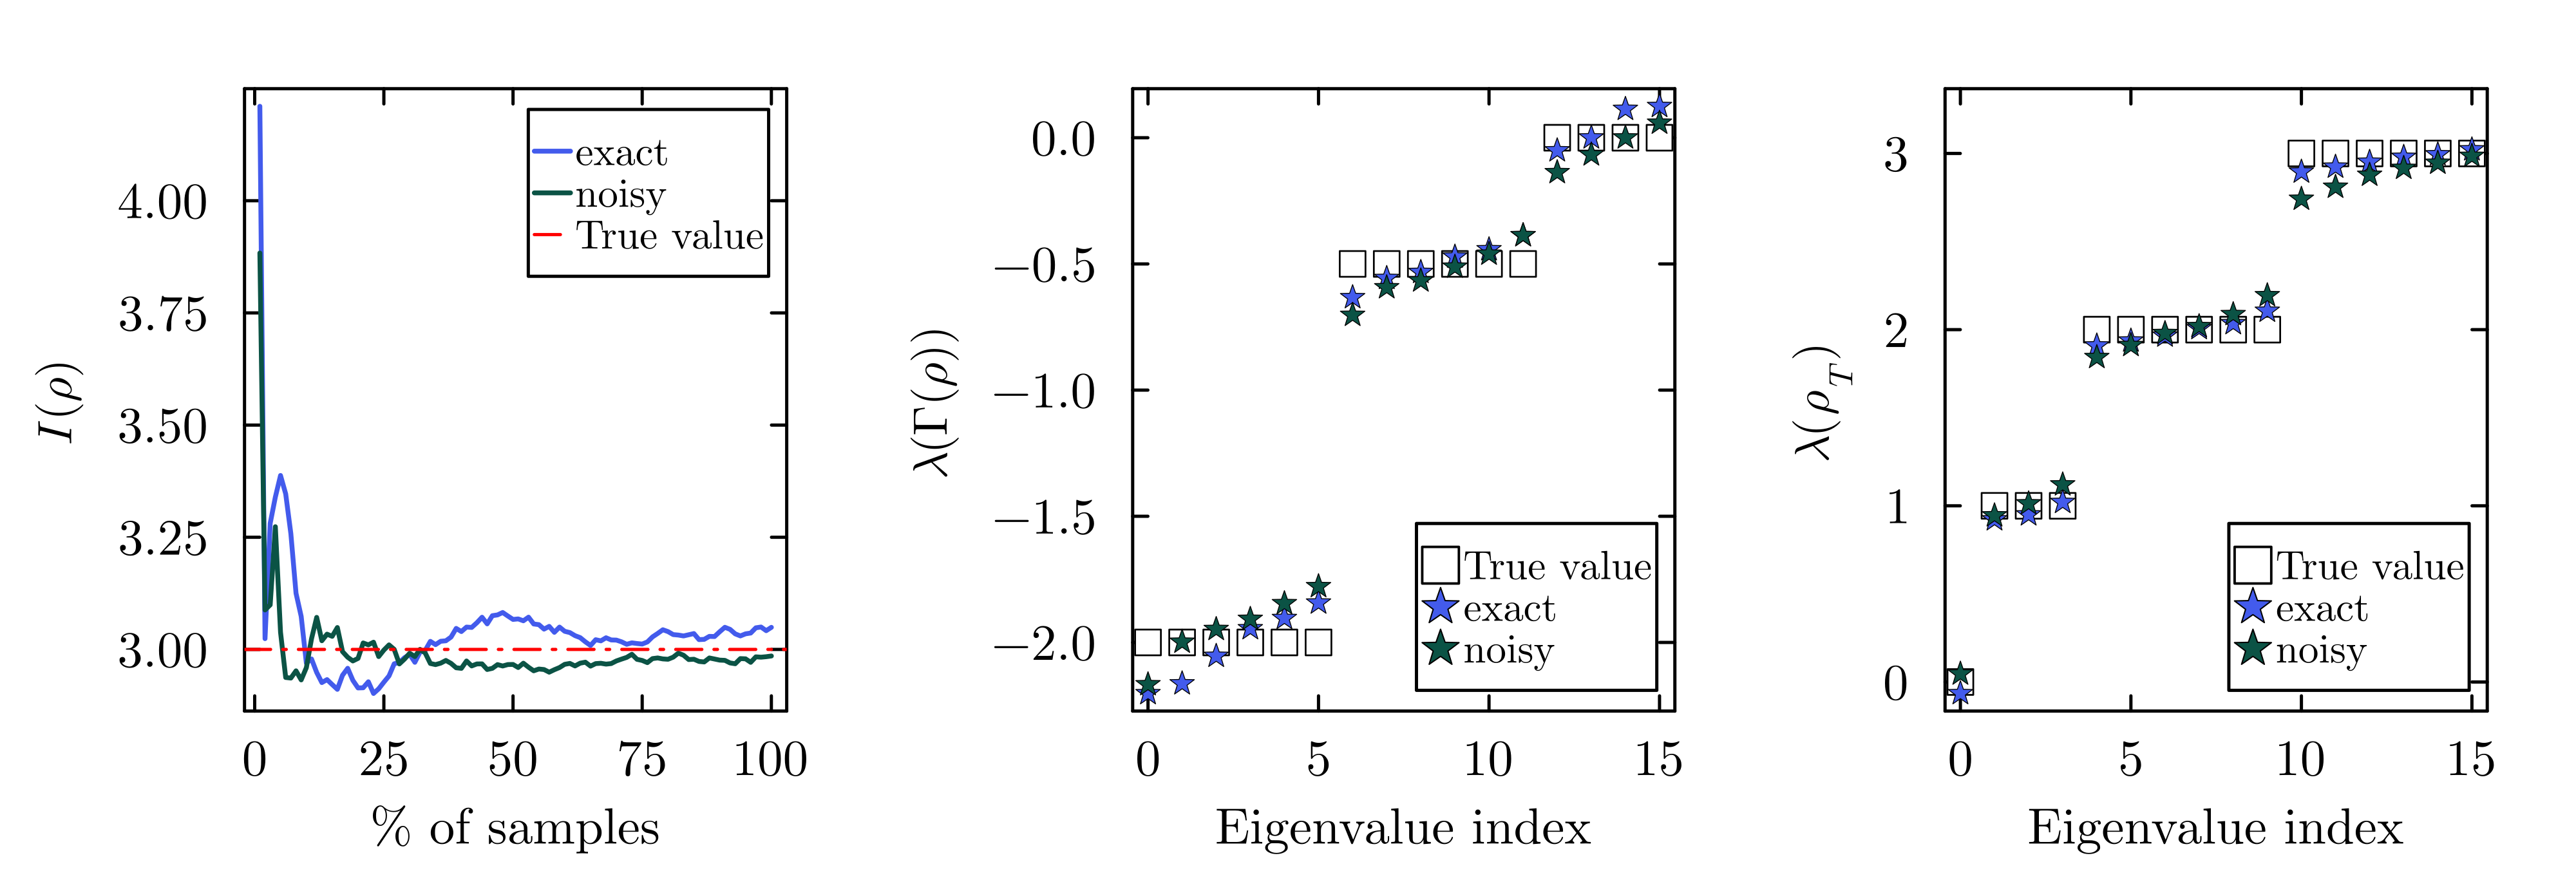

In [11]:
plot_invariant(snapshots, ["exact", "noisy"], [niceblue, green], dm)

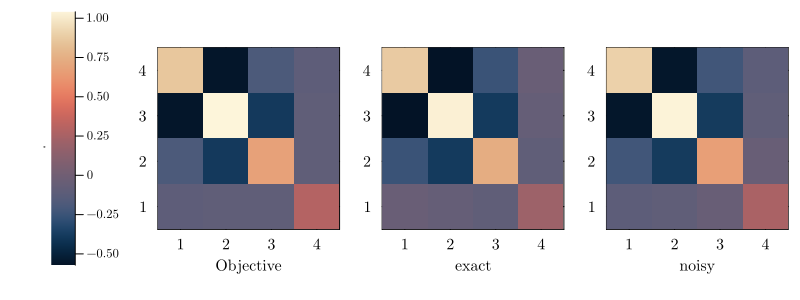

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [12]:
plot_two_point_correlators(snapshots, ["exact", "noisy"], dm)

In [15]:
plot_binned_probabilities(snapshots, ["truth", "exact", "noisy"], [niceblue, :orange, green], dm)